In [1]:
# i switched to google colab and checking if Nvidia GPU is working
!nvidia-smi

Thu Nov 20 20:25:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Install Dependencies

In [2]:
!pip install -q gdown inference-gpu supervision

In [3]:
# accesing directories
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir("drive/MyDrive/soccer_video_to_data/03 Data")
os.getcwd()

'/content/drive/MyDrive/soccer_video_to_data/03 Data'

In [ ]:
# this was when i was running it locally

#import os
#os.getcwd()
#os.chdir("../03 Data")

In [5]:
DATA_dir = os.getcwd()
print(DATA_dir)

/content/drive/MyDrive/soccer_video_to_data/03 Data


In [6]:
pip install git+https://github.com/roboflow/sports.git

  Cloning https://github.com/roboflow/sports.git to /tmp/pip-req-build-7_ib_0i3
  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/sports.git /tmp/pip-req-build-7_ib_0i3
  Resolved https://github.com/roboflow/sports.git to commit 42c80c06b6b65a7f89455b89fe31cdf4c38ba227
  Preparing metadata (setup.py) ... done


In [ ]:
# download the videos for demos
#!gdown -O "{DATA_dir}/0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
#!gdown -O "{DATA_dir}/2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
#!gdown -O "{DATA_dir}/08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
#!gdown -O "{DATA_dir}/573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
#!gdown -O "{DATA_dir}/121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

In [7]:
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## Ball, Players, Goalkeepers, and Referees detection


In [8]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/20"
PLAYER_DETECTION_MODEL = get_model(
    model_id=PLAYER_DETECTION_MODEL_ID,
    api_key=ROBOFLOW_API_KEY
)

ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM2 model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM2_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM3 model. Install SAM3 dependencies and set CORE_MODEL_SAM3_ENABLED to True.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.To suppress this warning, set CORE_MODEL_GAZE_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support GroundingDINO model. Use pip install 'inference[grounding-dino]' to install missing requirements.To suppress this warning, set CO

In [ ]:
# This is the local version.

#from inference import get_model
#from dotenv import load_dotenv

#load_dotenv()
#ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")
#PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/20"
#PLAYER_DETECTION_MODEL = get_model(
#    model_id=PLAYER_DETECTION_MODEL_ID,
#    api_key=ROBOFLOW_API_KEY
#)

In [10]:
from tqdm import tqdm

STRIDE = 30
PLAYER_ID = 2

def extract_crops(source_video_path: str):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=STRIDE)

    crops=[]
    for frame in tqdm(frame_generator, desc='collecting crops'):
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id== PLAYER_ID]
        crops += [
            sv.crop_image(frame, xyxy)
            for xyxy
            in detections.xyxy
        ]
    return crops

In [11]:
crops = extract_crops(SOURCE_VIDEO_PATH)

collecting crops: 25it [00:21,  1.14it/s]


In [12]:
len(crops)

501

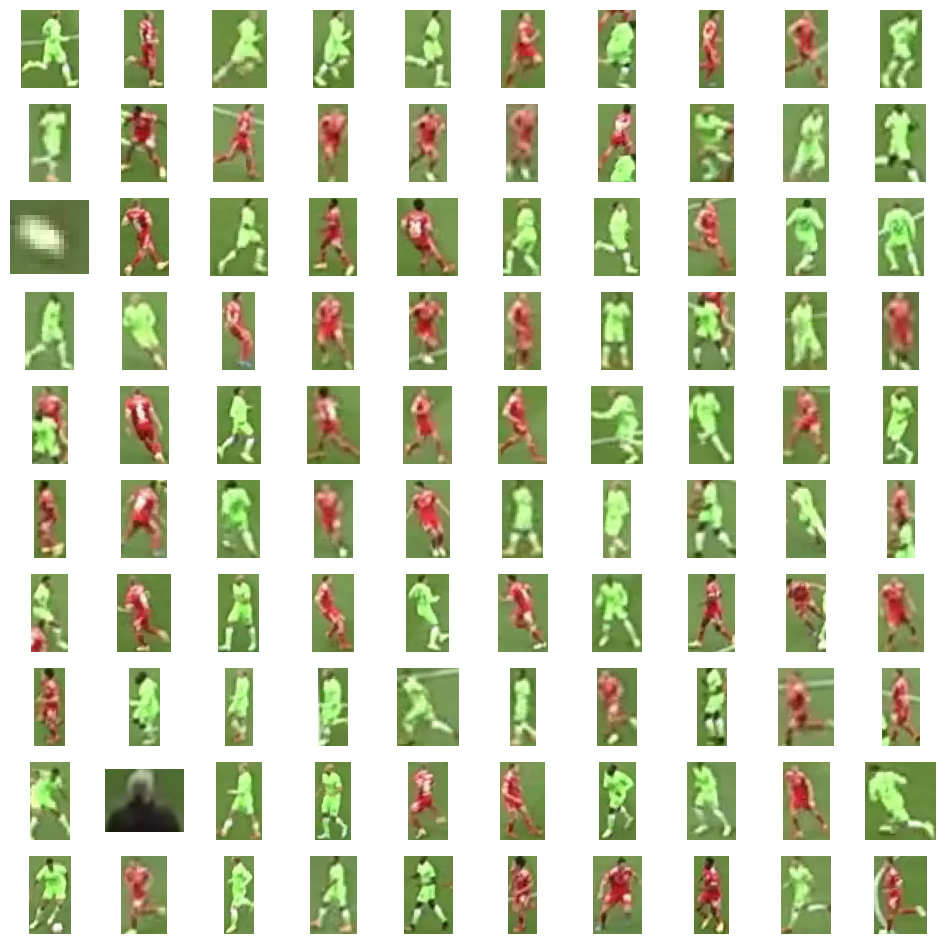

In [13]:
sv.plot_images_grid(crops[:100], grid_size=(10,10))

In [14]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [15]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []

with torch.no_grad():
    for batch in tqdm(batches, desc='embeddings extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors='pt').to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)


embeddings extraction: 16it [00:06,  2.52it/s]


In [16]:
data.shape

(501, 768)

In [17]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [18]:
projections = REDUCER.fit_transform(data)

In [19]:
projections.shape

(501, 3)

In [20]:
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [21]:
clusters[:10]

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0], dtype=int32)

In [22]:
team_0 = [
    crop
    for crop, cluster
    in zip(crops, clusters)
    if cluster ==0
]

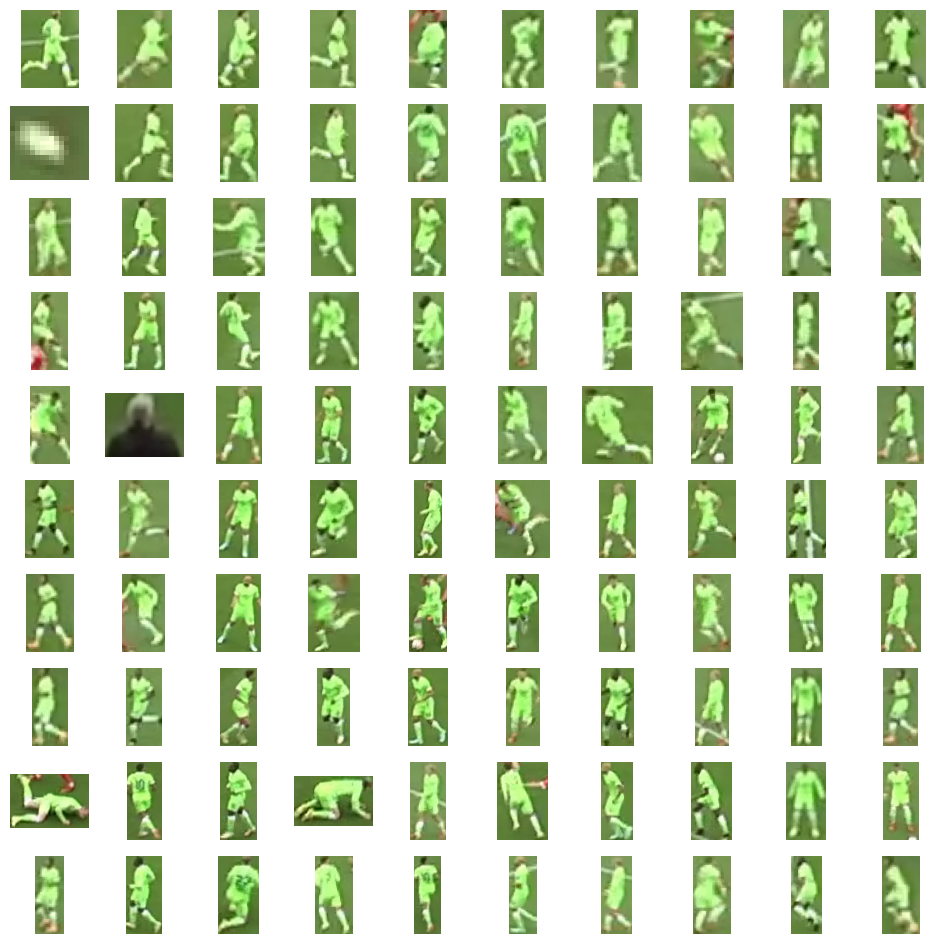

In [23]:
sv.plot_images_grid(team_0[:100], grid_size=(10, 10))

In [28]:
def resolve_goalkeepers_team_id(players_detections: sv.Detections,
                                goalkeepers_detections: sv.Detections
                                ):

  goalkeepers_xy = goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
  players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

  team_0_centroid = players_xy[players_detections.class_id ==0].mean(axis=0)
  team_1_centroid = players_xy[players_detections.class_id ==1].mean(axis=0)

  goalkeepers_team_ids = []
  for goalkeeper_xy in goalkeepers_xy:
    dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
    dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
    goalkeepers_team_ids.append(0 if dist_0 < dist_1 else 1)

  return np.array(goalkeepers_team_ids)

collecting crops: 25it [00:10,  2.32it/s]
Embedding extraction: 16it [00:06,  2.41it/s]
  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.86it/s]
  0%|          | 1/750 [00:00<04:46,  2.62it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.85it/s]
  0%|          | 2/750 [00:00<04:49,  2.58it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.95it/s]
  0%|          | 3/750 [00:01<04:47,  2.59it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.93it/s]
  1%|          | 4/750 [00:01<04:46,  2.60it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.19it/s]
  1%|          | 5/750 [00:01<04:42,  2.63it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  4.17it/s]
  1%|          | 6/750 [00:02<04:39,  2.66it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [

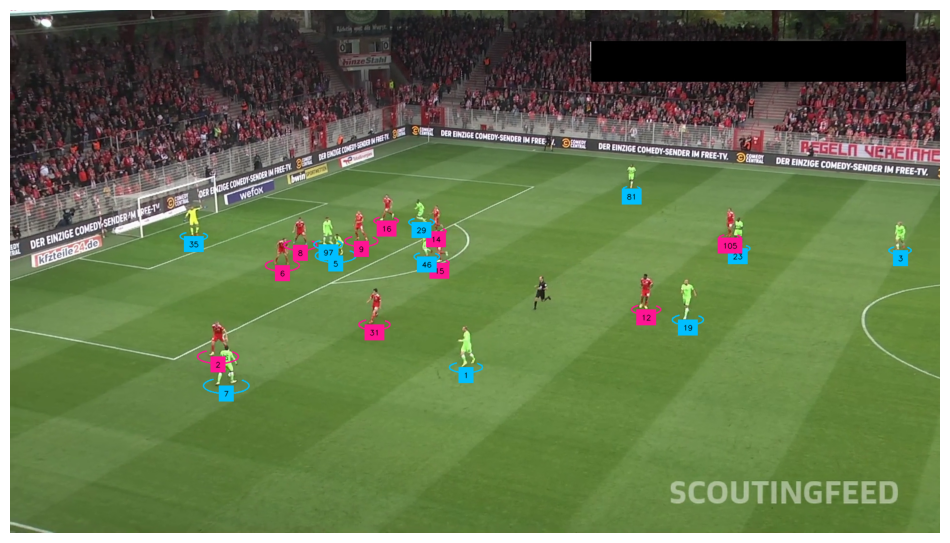

In [31]:
from tqdm import tqdm
import supervision as sv
from sports.common.team import TeamClassifier


SOURCE_VIDEO_PATH = f"{DATA_dir}/121364_0.mp4"
TARGET_VIDEO_PATH = f"{DATA_dir}/121364_0_results_6.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2

crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

ellipse_annotator = sv.EllipseAnnotator(
    color = sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness = 2
)

label_annotator = sv.LabelAnnotator(
    color = sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = tracker.update_with_detections(all_detections)

        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
            players_detections, goalkeepers_detections
        )

        all_detections = sv.Detections.merge([players_detections, goalkeepers_detections])
        all_detections.class_id = all_detections.class_id.astype(int) # added this to ensure all_detections were integers


        labels = [
        f"{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
        ]

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)

        video_sink.write_frame(annotated_frame)

sv.plot_image(annotated_frame)